<a href="https://colab.research.google.com/github/tonyzamyatin/learning-pytorch/blob/master/fcc-course/02_nn_classifiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. PyTorch Neural Network Classification

Online course book: https://www.learnpytorch.io/02_pytorch_classification/

In [1]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Make classification data and get it ready
We will create a small toy dataset to practice classification with PyTorch.

In [2]:
import sklearn

In [3]:
from sklearn.datasets import make_circles#

# Make 1000 samples
n = 1000

X, y = make_circles(n, noise=0.03, random_state=42)

len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n{X[:5]}")
print(f"First 5 samples of y:\n{y[:5]}")

First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
[1 1 1 1 0]


In [5]:
import pandas as pd

cicles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y})

cicles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


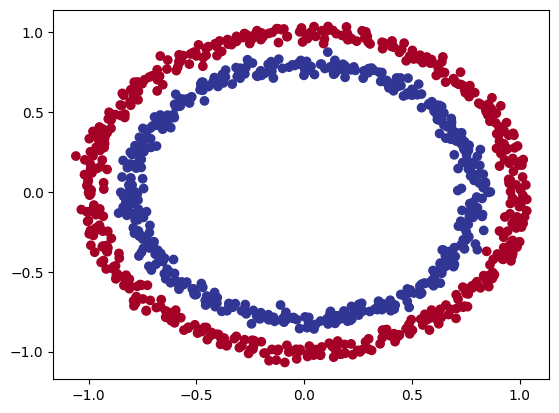

In [6]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

### 1.1. Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

### 1.2. Turn data into tensors and create train and test splits

In [8]:
import torch
torch.__version__

'2.3.1+cu121'

First we need to convert our data to tensors and the correct datatype. Remember, the default datatype for floats in NumPy is float64 whereas in PyTorch it is float32.

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [11]:
X_train.shape, X_train[:5], y_train.shape, y_train[:5]

(torch.Size([800, 2]),
 tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 torch.Size([800]),
 tensor([1., 0., 0., 0., 1.]))

### 1.3 Setup dataset and `DataLoader`

We can use some PyTorch wrappers to make iterating over the datasets in batches more convenient, namely `torch.utils.data.TensorDataset` and `torch.utils.data.DataLoader`.

In [45]:
from torch.utils.data import TensorDataset, DataLoader

def get_data_loaders(train_ds, test_ds, batch_size=32):
  return DataLoader(train_ds, batch_size), DataLoader(test_ds, batch_size)

train_ds = TensorDataset(X_train.to(device), y_train.to(device))
test_ds = TensorDataset(X_test.to(device), y_test.to(device))

train_dl, test_dl = get_data_loaders(train_ds, test_ds, batch_size=32)

## 2. Build a model

In [46]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [47]:
class CircleModelV0(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_2(self.layer_1(x))

In [48]:
model_0 = CircleModelV0().to(device)

model_0.state_dict(), next(model_0.parameters()).device

(OrderedDict([('layer_1.weight',
               tensor([[-0.4577,  0.5161],
                       [-0.3215, -0.1418],
                       [-0.7034,  0.4732],
                       [ 0.5357,  0.2577],
                       [-0.4930, -0.6979]])),
              ('layer_1.bias',
               tensor([-0.5743,  0.5273,  0.3395,  0.5950,  0.3704])),
              ('layer_2.weight',
               tensor([[ 0.1132, -0.0044, -0.3401, -0.3832, -0.4183]])),
              ('layer_2.bias', tensor([0.1831]))]),
 device(type='cpu'))

In [49]:
# Let's replicate the model above using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

## 3. Setup loss function and optimizer

In [50]:
# 2.1 Setup loss function and opitmizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [51]:
# Calculate accuracy
def accuracy_fn(y_pred, y_true):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 4. Create training and test loop

### 4.1. Raw logits -> prediction probabilities -> prediction label

The **logits** are the raw outputs of the model. To turn the logits into a probabiltiy distribution we pass them to an acitvation function (e.g. sigmoid for binary classification or softmax for multilabel classification). Afterward, we either round the probabilities (in case of binary classification) or take the argmax (for mulitlabel classification).

In [52]:
model_0.eval()
with torch.inference_mode():
  y_pred_logits = model_0(X_test.to(device)[:5])
  y_pred_probs = torch.sigmoid(y_pred_logits)
  y_pred_labels = torch.round(y_pred_probs)

y_pred_logits.squeeze(), y_pred_logits.squeeze(), y_pred_labels.squeeze()

(tensor([-0.9596, -0.9741, -0.7834, -1.0101, -0.5642]),
 tensor([-0.9596, -0.9741, -0.7834, -1.0101, -0.5642]),
 tensor([0., 0., 0., 0., 0.]))

### 4.2 Training and testing loop


In [53]:
import numpy as np

def batch_loss(model, loss_fn, acc_fn, xb, yb, opt=None):
  y_logits = model(xb).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  # loss = loss_fn(torch.sigmoid(y_logits), y_train) # Using nn.BCELoss you need torch.sigmoid()
  loss = loss_fn(y_logits, yb) # Using nn.BCEWithLogitsLoss works with raw logits
  accuracy = acc_fn(y_pred, yb)

  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()

  return loss.item(), accuracy, len(xb)

def fit(epochs, model, loss_fn, opt, train_dl, test_dl, acc_fn):
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      batch_loss(model, loss_fn, acc_fn, xb, yb, opt)

    if epoch % 10 == 0:
      model.eval()
      with torch.inference_mode():
        batch_losses, batch_acc, batch_sizes = zip(
            *[batch_loss(model, loss_fn, acc_fn, xb, yb) for xb, yb in test_dl]
        )
        test_loss = np.sum((np.multiply(batch_losses, batch_sizes))) / np.sum(batch_sizes)
        test_acc = np.sum((np.multiply(batch_acc, batch_sizes))) / np.sum(batch_sizes)

      print(f"Epoch {epoch}: test loss {test_loss:.5f}, accuracy {test_acc:.2f}")

In [54]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Fit the model
fit(100, model_0, loss_fn, optimizer, train_dl, test_dl, accuracy_fn)

Epoch 0: test loss 0.69821, accuracy 50.00
Epoch 10: test loss 0.69398, accuracy 52.00
Epoch 20: test loss 0.69437, accuracy 50.00
Epoch 30: test loss 0.69460, accuracy 49.50
Epoch 40: test loss 0.69470, accuracy 50.00
Epoch 50: test loss 0.69475, accuracy 49.00
Epoch 60: test loss 0.69476, accuracy 49.00
Epoch 70: test loss 0.69477, accuracy 49.00
Epoch 80: test loss 0.69477, accuracy 49.00
Epoch 90: test loss 0.69477, accuracy 49.00


## 5. Make predictions and evaluate the model

From the metrics it looks like our model is not leadning anything ...
Let's make some predictions and visualize them.

In [55]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [56]:
from helper_functions import plot_predictions, plot_decision_boundary

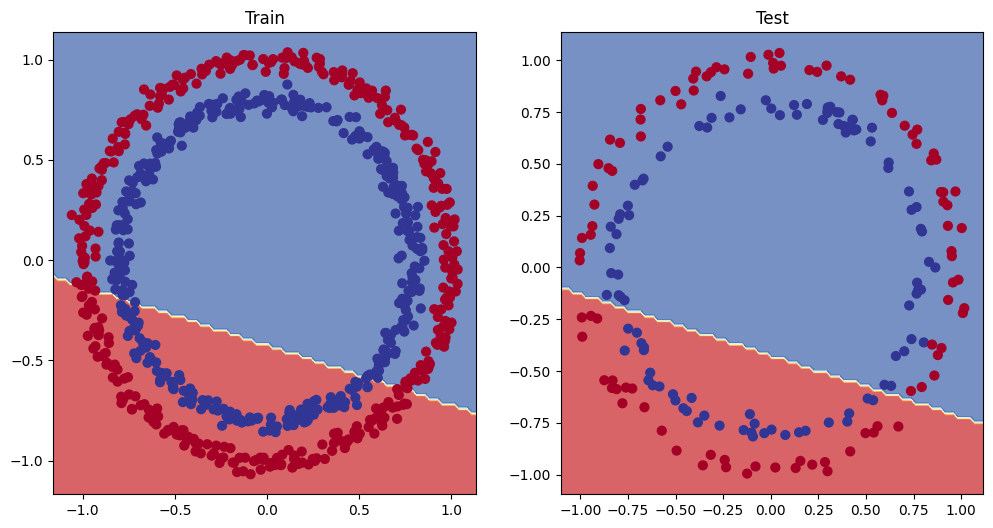

In [59]:
# Plot decision boundry of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

From the plot we can see that the model is trying to split the data in half using a stright line, which can only give 50% accuary at best for this dataset.

In machine learning terms, the model is **underfitting** the data.

## 6. Improve the model
In case of underfitting there are several things we can try to improve the models performance (focusing on the model not the data):

1. Make the model **deeper** by adding more hidden layers. Each hidden layer potentially allows the model to learn more complex patterns. However, add to many and the model becomes overly complex and **overfits** to the training dataset.
2. In the same way we can make the model **wider** by adding more neurons to the existing hidden layers.
3. Try a different **activation function**. In our case the problem is that the data is non-linear but we use a linear activation function.
4. Try different **loss function**. Loss functions are problem specific, e.g. you cannot use binary cross-entropy for multi-class classification problems.
5. Increase **training time** (number of epochs). Maybe the model did not converge yet (didn't see enough training data to learn the patterns). In this case, training the model for longer can help.
6. Adjust the **learning rate**. The learning rate controls the step size. Make it too large and the model will overshoot, make it too small and the model will learn very slowly.
7. Employ **transfer learning** by using the a pre-trained model from a problem domain similar to yours and adjust it to your problem.

### 6.1 Building a model with non-linearity

The first model was useless because it was nothing but a linear classifier. In fact, no matter how many hidden layers or neureons we added, it would all boil down to a linear combination of the input vector and do nothing better than a simple single layer perceptron.

What is missing is **non-linearity**. To build a model that is able to learn non-linear patterns we need to add non-linear activation functions in between the hidden layers. The most common ones are:
- **Sigmoid**
- **Tangens hyperbolicus**
- **ReLU**

Although sigmoid and tanh resemble more what we would expect a non-linear function to look like, ReLU approximates the two well enough and with enough hidden layers can learn complex non-linear patterns just as well as the other two. The upside to using ReLU is that it is hihgly performant since it is easily computable.

#### Non-linear model with ReLU

In [98]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_relu = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
).to(device)

model_relu

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
)

In [99]:
optim_relu = torch.optim.SGD(params=model_relu.parameters(), lr=0.1)

In [100]:
fit(epochs=1000,
    model=model_relu,
    loss_fn=loss_fn,
    opt=optim_relu,
    train_dl=train_dl,
    test_dl=test_dl,
    acc_fn=accuracy_fn)

Epoch 0: test loss 0.69611, accuracy 48.00
Epoch 10: test loss 0.68867, accuracy 56.50
Epoch 20: test loss 0.68540, accuracy 54.50
Epoch 30: test loss 0.68346, accuracy 52.50
Epoch 40: test loss 0.68100, accuracy 51.50
Epoch 50: test loss 0.67457, accuracy 53.00
Epoch 60: test loss 0.65993, accuracy 58.50
Epoch 70: test loss 0.62177, accuracy 72.50
Epoch 80: test loss 0.58383, accuracy 76.00
Epoch 90: test loss 0.55273, accuracy 76.00
Epoch 100: test loss 0.52628, accuracy 76.00
Epoch 110: test loss 0.50273, accuracy 78.00
Epoch 120: test loss 0.48100, accuracy 81.00
Epoch 130: test loss 0.46417, accuracy 81.00
Epoch 140: test loss 0.45111, accuracy 82.50
Epoch 150: test loss 0.43787, accuracy 83.50
Epoch 160: test loss 0.42301, accuracy 84.00
Epoch 170: test loss 0.41104, accuracy 86.00
Epoch 180: test loss 0.39770, accuracy 88.00
Epoch 190: test loss 0.38716, accuracy 88.00
Epoch 200: test loss 0.37715, accuracy 87.50
Epoch 210: test loss 0.36785, accuracy 88.50
Epoch 220: test loss 

## 6.2 Evaluate non-linear model and compare to lineaer model

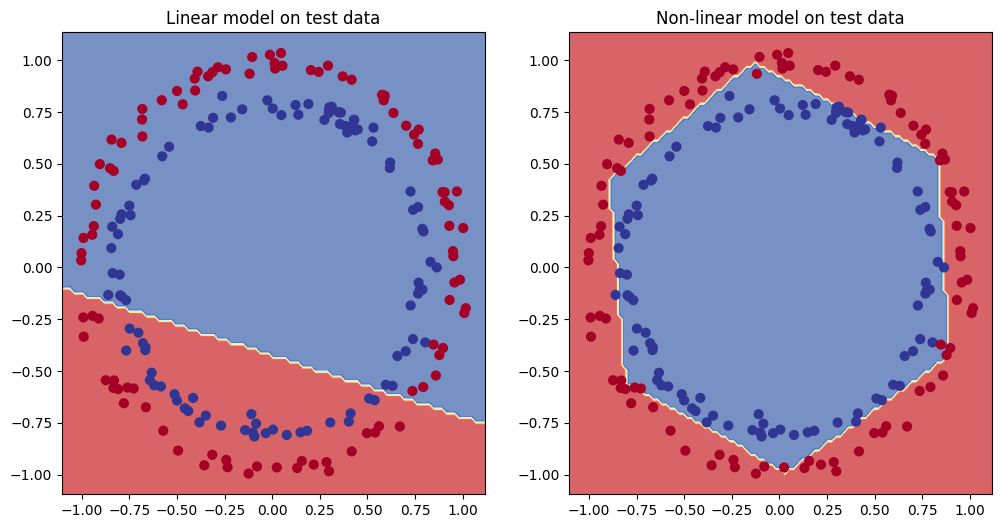

In [101]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Linear model on test data")
plot_decision_boundary(model_0, X_test, y_test)
plt.subplot(1, 2, 2)
plt.title("Non-linear model on test data")
plot_decision_boundary(model_relu, X_test, y_test)

#### Non-linear model with Sigmoid

In [102]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_sigm = nn.Sequential(
    nn.Linear(2, 5),
    nn.Sigmoid(),
    nn.Linear(5, 1)
).to(device)

model_sigm

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=5, out_features=1, bias=True)
)

In [103]:
optim_sigm = torch.optim.SGD(params=model_sigm.parameters(), lr=0.1)

In [104]:
fit(epochs=1500,
    model=model_sigm,
    loss_fn=loss_fn,
    opt=optim_sigm,
    train_dl=train_dl,
    test_dl=test_dl,
    acc_fn=accuracy_fn)

Epoch 0: test loss 0.69390, accuracy 50.00
Epoch 10: test loss 0.69379, accuracy 50.00
Epoch 20: test loss 0.69382, accuracy 50.00
Epoch 30: test loss 0.69385, accuracy 50.00
Epoch 40: test loss 0.69387, accuracy 50.00
Epoch 50: test loss 0.69389, accuracy 50.00
Epoch 60: test loss 0.69392, accuracy 50.00
Epoch 70: test loss 0.69394, accuracy 50.00
Epoch 80: test loss 0.69396, accuracy 50.00
Epoch 90: test loss 0.69397, accuracy 50.00
Epoch 100: test loss 0.69399, accuracy 50.00
Epoch 110: test loss 0.69401, accuracy 50.00
Epoch 120: test loss 0.69403, accuracy 50.00
Epoch 130: test loss 0.69404, accuracy 50.00
Epoch 140: test loss 0.69406, accuracy 50.00
Epoch 150: test loss 0.69408, accuracy 50.00
Epoch 160: test loss 0.69409, accuracy 50.00
Epoch 170: test loss 0.69411, accuracy 50.00
Epoch 180: test loss 0.69413, accuracy 50.50
Epoch 190: test loss 0.69415, accuracy 51.50
Epoch 200: test loss 0.69416, accuracy 53.00
Epoch 210: test loss 0.69418, accuracy 54.00
Epoch 220: test loss 

In our setup, the sigmoid model learns a lot slower than the ReLU model. It will be intersting to explore why.

Let's compare decision boundary of ReLU and sigmoid model

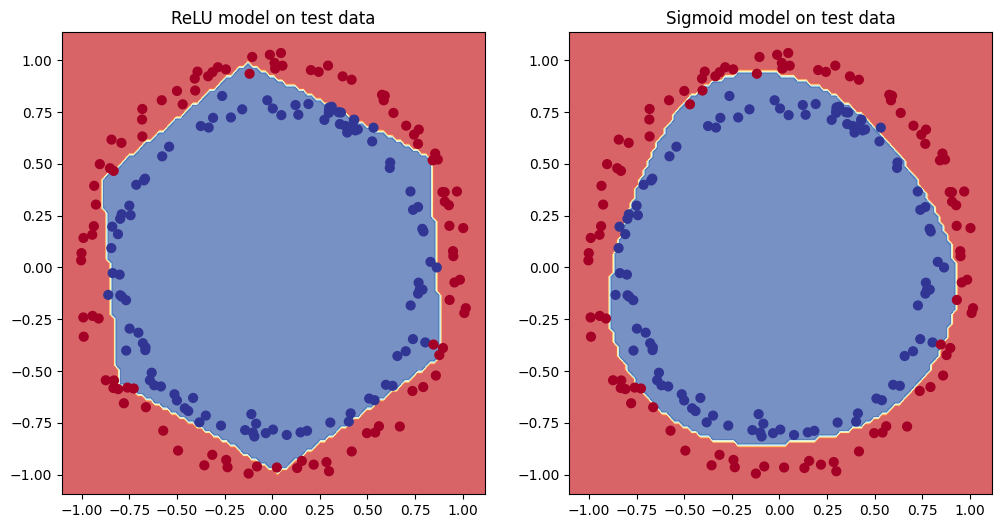

In [105]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("ReLU model on test data")
plot_decision_boundary(model_relu, X_test, y_test)
plt.subplot(1, 2, 2)
plt.title("Sigmoid model on test data")
plot_decision_boundary(model_sigm, X_test, y_test)

Comparing the decision boundaries of the ReLU classifier and the sigmoid classifier, the ReLU classifier learns rough edges drawn with straight lines, whereas the sigmoid classifier learns round edges.